# Validierung auf neun Daten aus Github

In [39]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import optuna
import joblib
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from lime.lime_tabular import LimeTabularExplainer
from captum.attr import DeepLiftShap
from captum.attr import DeepLift

In [40]:
df = pd.read_pickle('df_neutor_validation.pkl')

In [41]:
df

,Datum,Zeit,Wochentag,Neutor (gesamt),Feiertag,Semesterferien,Ferien,Lockdown,Verkehr_vor_einer_Woche,Verkehrs_Differenz,Neutor_FR_stadtauswärts_vor_einer_Woche,Neutor_FR_stadteinwärts_vor_einer_Woche,Neutor_FR_stadtauswärts_Differenz,Neutor_FR_stadteinwärts_Differenz,Top4_letzte_Woche,Berufsverkehr,Jahreszeit
0,2023-01-01,00:00:00,Sonntag,73.0,0,1,1,0,39.0,34.0,20.0,19.0,23.0,11.0,False,False,Winter
1,2023-01-01,01:00:00,Sonntag,193.0,0,1,1,0,34.0,159.0,14.0,20.0,89.0,70.0,False,False,Winter
2,2023-01-01,02:00:00,Sonntag,240.0,0,1,1,0,38.0,202.0,25.0,13.0,117.0,85.0,False,False,Winter
3,2023-01-01,03:00:00,Sonntag,279.0,0,1,1,0,10.0,269.0,10.0,0.0,151.0,118.0,False,False,Winter
4,2023-01-01,04:00:00,Sonntag,194.0,0,1,1,0,15.0,179.0,8.0,7.0,129.0,50.0,False,False,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2023-01-07,19:00:00,Samstag,405.0,0,0,0,0,365.0,40.0,192.0,173.0,23.0,17.0,True,False,Winter
164,2023-01-07,20:00:00,Samstag,321.0,0,0,0,0,303.0,18.0,139.0,164.0,11.0,7.0,False,False,Winter
165,2023-01-07,21:00:00,Samstag,238.0,0,0,0,0,207.0,31.0,105.0,102.0,34.0,-3.0,False,False,Winter
166,2023-01-07,22:00:00,Samstag,189.0,0,0,0,0,149.0,40.0,66.0,83.0,48.0,-8.0,False,False,Winter


### Vorverarbeitungsschritte aus dem Training

In [42]:
def preprocess_data(data, is_new_data=False):
    X = data.drop(columns=["Neutor (gesamt)"])
    y = data["Neutor (gesamt)"]

    # "Zeit"-Spalte in datetime konvertieren
    X['Zeit'] = pd.to_datetime(X['Zeit'], format='%H:%M:%S')
    
    # Stunde und Minute extrahieren
    X['Stunde'] = X['Zeit'].dt.hour
    X['Minute'] = X['Zeit'].dt.minute
    
    # Datum zerlegen
    X['Jahr'] = X['Datum'].dt.year
    X['Monat'] = X['Datum'].dt.month
    X['Tag'] = X['Datum'].dt.day

    # One-Hot-Encoding für "Wochentag" und "Jahreszeit"
    X = pd.get_dummies(X, columns=['Wochentag', 'Jahreszeit'])

    # Wenn der neue Datensatz zu klein ist, kommen nicht alle Jahreszeiten vor
    if is_new_data:
        jahreszeiten = ['Jahreszeit_Frühling', 'Jahreszeit_Sommer', 'Jahreszeit_Herbst', 'Jahreszeit_Winter']
        for jz in jahreszeiten:
            if jz not in X.columns:
                X[jz] = False

    # "Zeit" und "Datum" entfernen
    X = X.drop(columns=['Zeit', 'Datum'])

    if is_new_data:
        # Fehlende Spalten hinzufügen und ihre Werte auf 0 setzen
        missing_columns = ["Jahreszeit_Frühling", "Jahreszeit_Herbst", "Jahreszeit_Sommer", "Neutor FR stadtauswärts", "Neutor FR stadteinwärts"]
        for col in missing_columns:
            if col not in X.columns:
                X[col] = 0

        X = X[column_names]

    return X, y

In [43]:
def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

#### Reihenfolge der Spaltennamen

In [44]:
df_columns = pd.read_csv('model_metadata/column_names.csv', header=None)
column_names = df_columns.iloc[1:, 0].tolist()

In [45]:
X_new, y_new = preprocess_data(df, is_new_data=True)

In [46]:
X_new = X_new[column_names]

In [47]:
scaler_X_lstm = joblib.load('scaler_lstm/scaler_X_lstm.pkl')
scaler_y_lstm = joblib.load('scaler_lstm/scaler_y_lstm.pkl')

scaler_X_gru = joblib.load('scaler_gru/scaler_X_gru.pkl')
scaler_y_gru = joblib.load('scaler_gru/scaler_y_gru.pkl')

In [48]:
X_new_scaled_lstm = scaler_X_lstm.transform(X_new)
y_new_scaled_lstm = scaler_y_lstm.transform(y_new.values.reshape(-1, 1))

X_new_scaled_gru = scaler_X_gru.transform(X_new)
y_new_scaled_gru = scaler_y_gru.transform(y_new.values.reshape(-1, 1))

In [49]:
def create_sequences(data, target, sequence_length):
    sequences = []
    target_seq = []
    
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(seq)
        target_seq.append(label)
    
    return np.array(sequences), np.array(target_seq)

In [50]:
sequence_length = 10
X_new_sequence_lstm, y_new_sequence_lstm = create_sequences(X_new_scaled_lstm, y_new_scaled_lstm, sequence_length)
X_new_sequence_gru, y_new_sequence_gru = create_sequences(X_new_scaled_gru, y_new_scaled_gru, sequence_length)

In [51]:
X_new_tensor_lstm = torch.Tensor(X_new_sequence_lstm)
y_new_tensor_lstm = torch.Tensor(y_new_sequence_lstm)

X_new_tensor_gru = torch.Tensor(X_new_sequence_gru)
y_new_tensor_gru = torch.Tensor(y_new_sequence_gru)

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.linear(lstm_out[:, -1, :])
        return output

In [53]:
input_size_lstm = X_new_tensor_lstm.shape[2]

loaded_best_params_lstm = pd.read_csv('model_metadata/best_params_lstm.csv').iloc[0].to_dict()

hidden_size_lstm = int(loaded_best_params_lstm["hidden_size"])
num_layers_lstm = int(loaded_best_params_lstm["num_layers"])

# Instanz des Modells erstellen
model_lstm = LSTMModel(input_size_lstm, hidden_size_lstm, num_layers_lstm)

# Modell laden
model_lstm.load_state_dict(torch.load('lstm_model_without_weather.pth'))

# Modell in den Evaluierungsmodus
model_lstm.eval()

with torch.no_grad():
    predictions_lstm = model_lstm(X_new_tensor_lstm)
predictions_lstm_original = scaler_y_lstm.inverse_transform(predictions_lstm.numpy())

In [54]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.linear(gru_out[:, -1, :])
        return output

In [55]:
input_size_gru = X_new_tensor_gru.shape[2]

loaded_best_params_gru = pd.read_csv('model_metadata/best_params_gru.csv').iloc[0].to_dict()

hidden_size_gru = int(loaded_best_params_gru["hidden_size"])
num_layers_gru = int(loaded_best_params_gru["num_layers"])

model_gru = GRUModel(input_size_gru, hidden_size_gru, num_layers_gru)

model_gru.load_state_dict(torch.load('gru_model_without_weather.pth'))

model_gru.eval()

with torch.no_grad():
    predictions_gru = model_gru(X_new_tensor_gru)
predictions_gru_original = scaler_y_gru.inverse_transform(predictions_gru.numpy())

In [57]:
new_data, _ = preprocess_data(df, is_new_data=True)

# Skalierung und Sequenzerstellung
new_data_scaled_lstm = scaler_X_lstm.transform(new_data)
new_data_sequences_lstm, _ = create_sequences(new_data_scaled_lstm, np.zeros(new_data_scaled_lstm.shape[0]), sequence_length)
new_data_tensor_lstm = torch.Tensor(new_data_sequences_lstm)

new_data_scaled_gru = scaler_X_gru.transform(new_data)
new_data_sequences_gru, _ = create_sequences(new_data_scaled_gru, np.zeros(new_data_scaled_gru.shape[0]), sequence_length)
new_data_tensor_gru = torch.Tensor(new_data_sequences_gru)

## XAI fuer LSTM

In [60]:
model_lstm_instance = LSTMModel(input_size_lstm, hidden_size_lstm, num_layers_lstm)

# Modell laden
model_lstm_instance.load_state_dict(torch.load('lstm_model_without_weather.pth'))
model_lstm_instance.eval()

# Anwendung von Captum DeepLiftShap
dl_shap_lstm = DeepLiftShap(model_lstm_instance)
baselines = torch.zeros_like(X_new_tensor_lstm)
attributions_lstm = dl_shap_lstm.attribute(X_new_tensor_lstm, baselines)

# Umwandeln der Attributionswerte in ein numpy-Array
attributions_lstm_numpy = attributions_lstm.detach().numpy()

/Users/danielzellner/Documents/Studium/Bachelorthesis/torch_tf/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


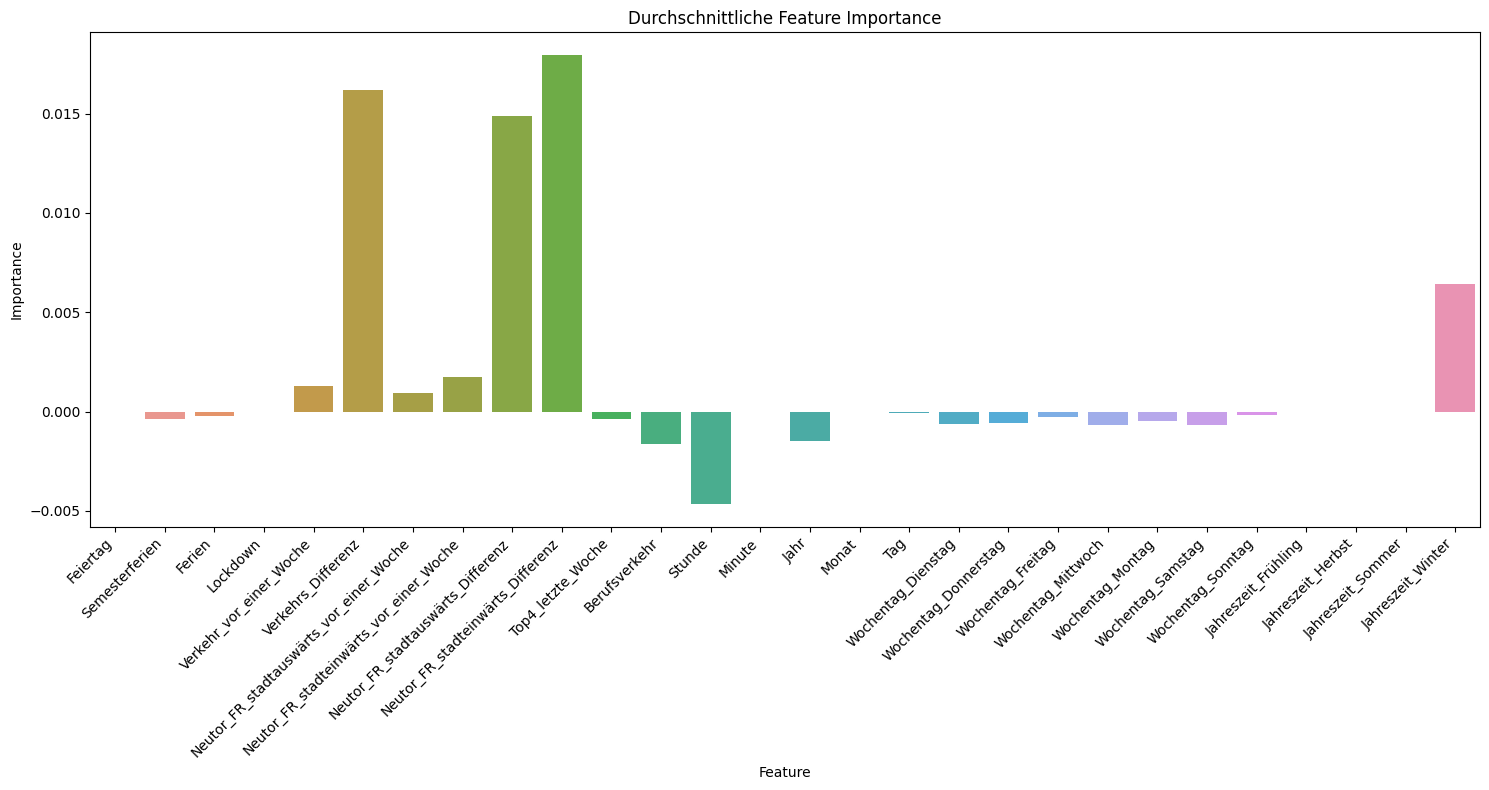

In [61]:
mean_attributions = np.mean(np.mean(attributions_lstm_numpy, axis=1), axis=0)

feature_names = column_names

plt.figure(figsize=(15, 8))
sns.barplot(x=feature_names, y=mean_attributions)
plt.title("Durchschnittliche Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("visualization/mean_feature_importance_lstm.png", dpi=300, bbox_inches="tight")

plt.show()

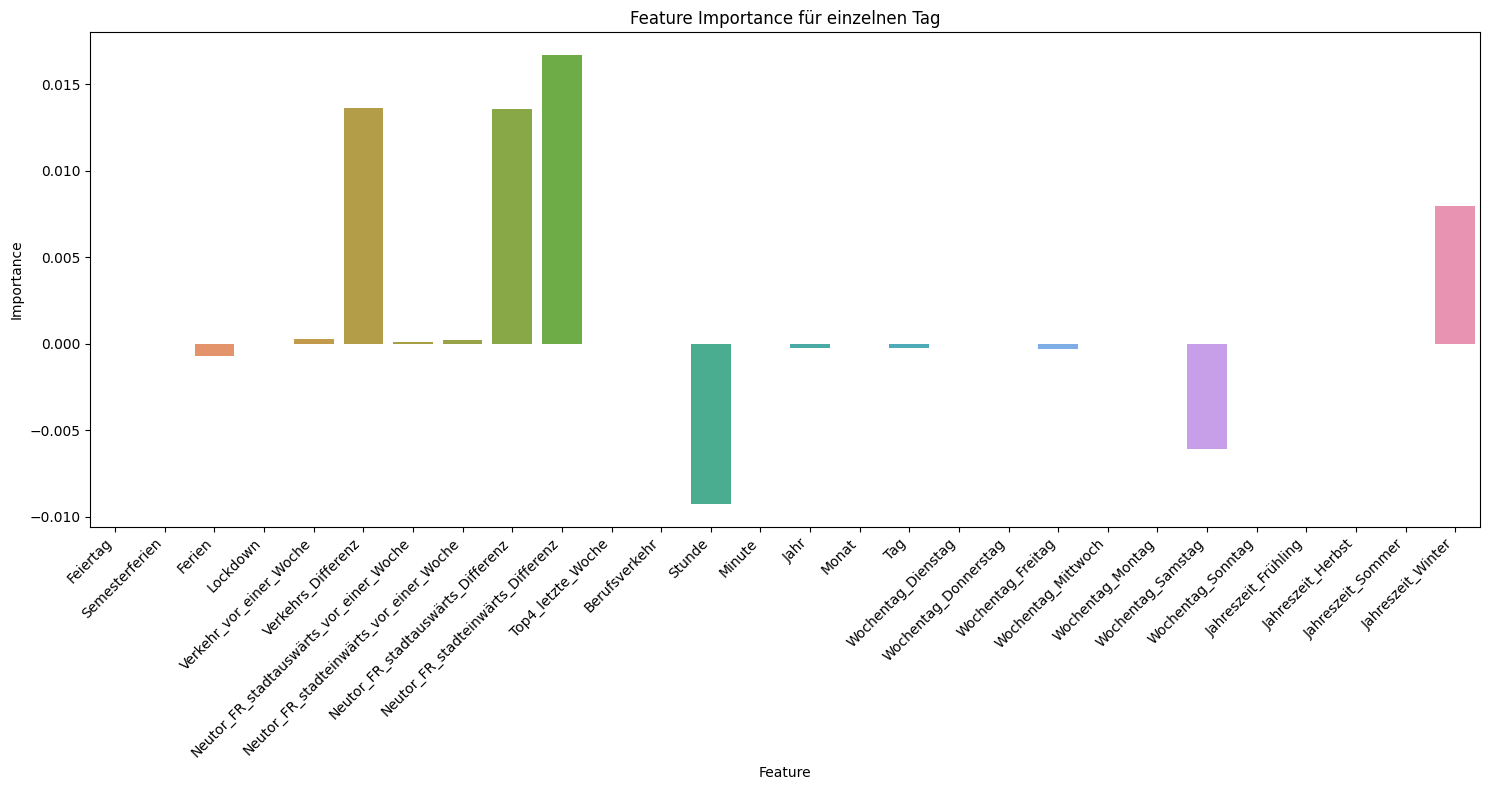

In [101]:
mean_day_attributions = np.mean(attributions_lstm_numpy[140], axis=0)

feature_names = column_names

plt.figure(figsize=(15, 8))
sns.barplot(x=feature_names, y=mean_day_attributions)
plt.title("Feature Importance für einzelnen Tag")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("visualization/feature_importance_tag_lstm.png", dpi=300, bbox_inches="tight")

plt.show()

In [66]:
print(new_data_sequences_lstm.shape)

(158, 10, 28)


### LIME

In [108]:
aggregated_data = new_data_sequences_lstm.mean(axis=1)

def model_predict_aggregated(data):
    tensor_data = torch.from_numpy(data).float().unsqueeze(1).repeat(1, new_data_sequences_lstm.shape[1], 1)
    output = model_lstm_instance(tensor_data)
    
    output_original_scale = scaler_y_lstm.inverse_transform(output.detach().numpy())
    
    return output_original_scale

# Explainer erstellen
explainer = LimeTabularExplainer(aggregated_data, 
                                 feature_names=column_names, 
                                 class_names=['Prediction'], 
                                 verbose=True, 
                                 mode='regression')

# Zeitpunkt in den Daten
i = 140
exp = explainer.explain_instance(aggregated_data[i], model_predict_aggregated, num_features=10)

# Visualisierung
exp.show_in_notebook(show_all=False, show_predicted_value=True)

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.title('LIME-Erklärung für LSTM')
plt.savefig('visualization/lime_lstm.png', bbox_inches='tight', dpi=1000)
plt.close()

Intercept 27.281189310206244
Prediction_local [78.35903626]
Right: 248.91505


In [112]:
print(len(aggregated_data))

158


## XAI fuer GRU

In [71]:
model_gru_instance = GRUModel(input_size_gru, hidden_size_gru, num_layers_gru) 

# GRU-Modell
model_gru_instance.load_state_dict(torch.load('gru_model_without_weather.pth'))  
model_gru_instance.eval()

# DeepShap
dl_shap_gru = DeepLiftShap(model_gru_instance)
baselines_gru = torch.zeros_like(X_new_tensor_gru)
attributions_gru = dl_shap_gru.attribute(X_new_tensor_gru, baselines_gru)

attributions_gru_numpy = attributions_gru.detach().numpy()

/Users/danielzellner/Documents/Studium/Bachelorthesis/torch_tf/lib/python3.9/site-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


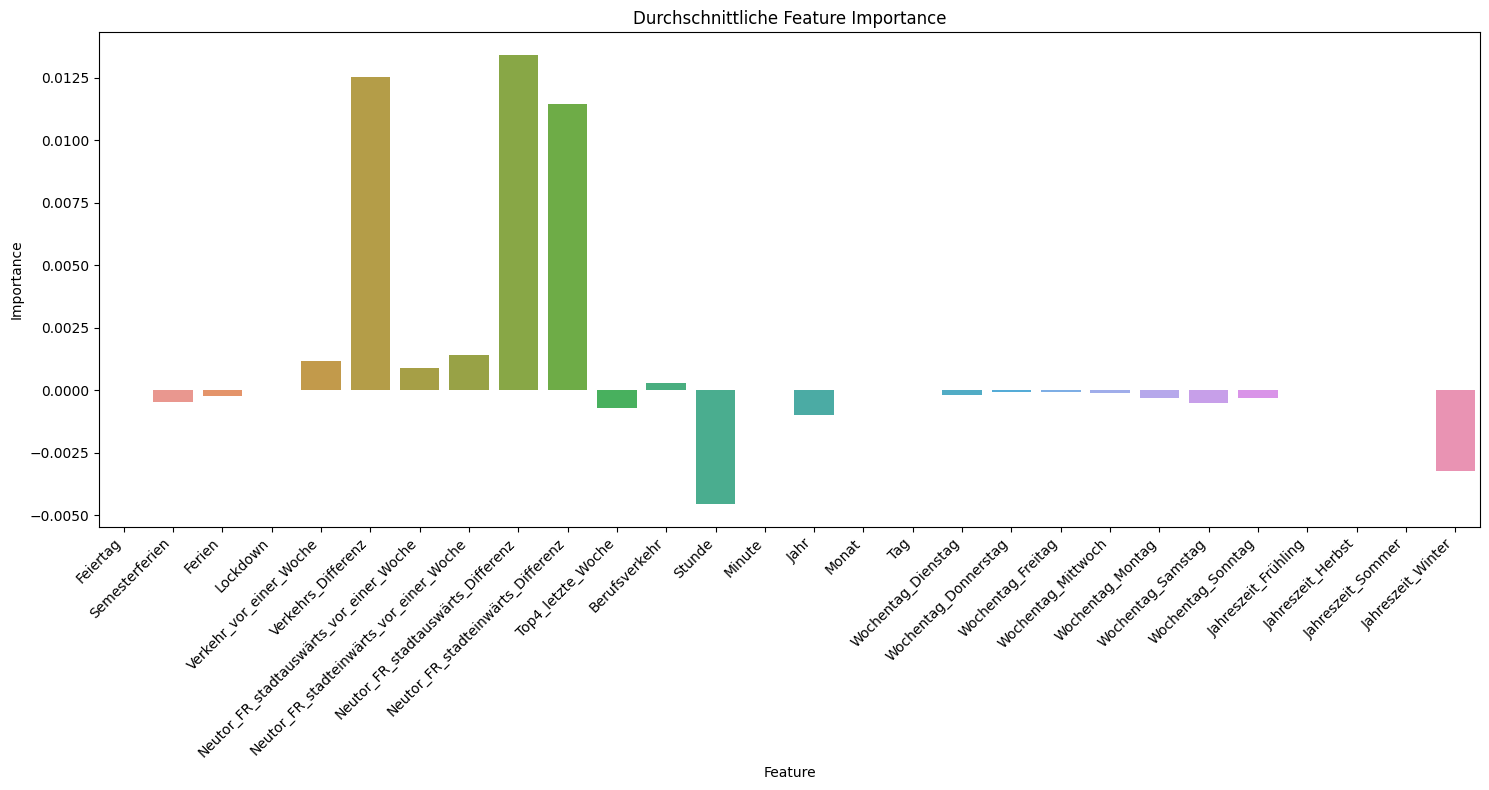

In [72]:
mean_attributions = np.mean(np.mean(attributions_gru_numpy, axis=1), axis=0)

feature_names = column_names

plt.figure(figsize=(15, 8))
sns.barplot(x=feature_names, y=mean_attributions)
plt.title("Durchschnittliche Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("visualization/mean_feature_importance_gru.png", dpi=300, bbox_inches="tight")

plt.show()

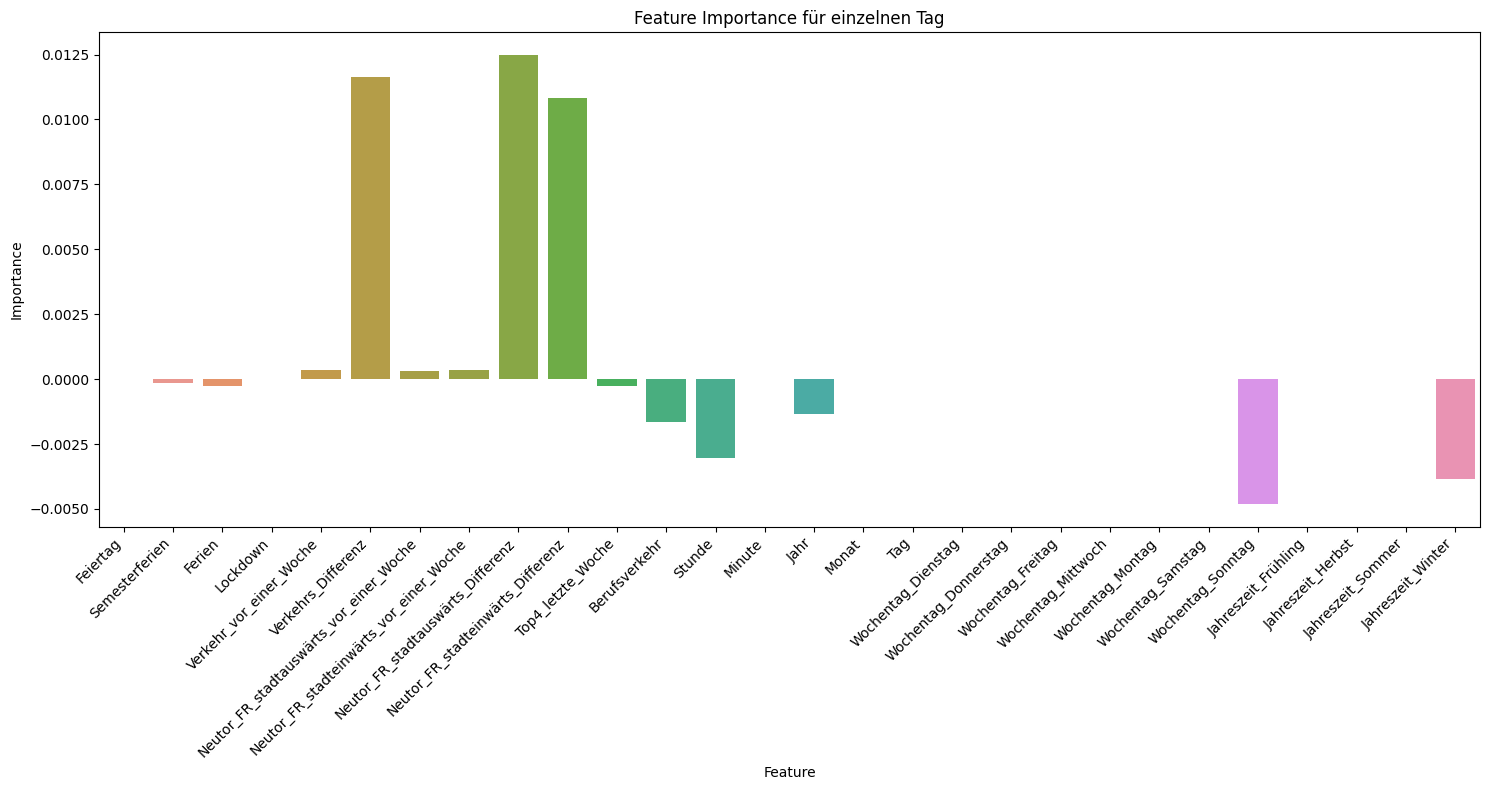

In [73]:
mean_day_attributions = np.mean(attributions_gru_numpy[9], axis=0)

feature_names = column_names

plt.figure(figsize=(15, 8))
sns.barplot(x=feature_names, y=mean_day_attributions)
plt.title("Feature Importance für einzelnen Tag")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig("visualization/feature_importance_tag_gru.png", dpi=300, bbox_inches="tight")

plt.show()

In [109]:
def model_predict_gru(data):
    data_scaled = scaler_X_gru.transform(data)
    tensor_data = torch.from_numpy(data_scaled).float().unsqueeze(1)
    output_scaled = model_gru_instance(tensor_data)
    output = scaler_y_gru.inverse_transform(output_scaled.detach().numpy())

    return output

X_new_2d_gru = X_new_scaled_gru.reshape(X_new_scaled_gru.shape[0], -1)

# Explainer erstellen
explainer_gru = LimeTabularExplainer(X_new_2d_gru,
                                     feature_names=column_names, 
                                     class_names=['Prediction'], 
                                     verbose=True, 
                                     mode='regression')

# Zeitpunkt
i = 140
exp_gru = explainer_gru.explain_instance(X_new_2d_gru[i], model_predict_gru, num_features=10)

# Visualisierung
exp_gru.show_in_notebook(show_all=False, show_predicted_value=True)

fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.title('LIME-Erklärung für GRU')
plt.savefig('visualization/lime_gru.png', bbox_inches='tight', dpi=1000)
plt.close()

Intercept 337.5711557876471
Prediction_local [342.94246008]
Right: 345.2403


/Users/danielzellner/Documents/Studium/Bachelorthesis/torch_tf/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [96]:
print(df.iloc[140])

Datum                                      2023-01-06 00:00:00
Zeit                                                  20:00:00
Wochentag                                              Freitag
Neutor (gesamt)                                          324.0
Feiertag                                                     0
Semesterferien                                               1
Ferien                                                       1
Lockdown                                                     0
Verkehr_vor_einer_Woche                                  245.0
Verkehrs_Differenz                                        79.0
Neutor_FR_stadtauswärts_vor_einer_Woche                  133.0
Neutor_FR_stadteinwärts_vor_einer_Woche                  112.0
Neutor_FR_stadtauswärts_Differenz                         44.0
Neutor_FR_stadteinwärts_Differenz                         35.0
Top4_letzte_Woche                                        False
Berufsverkehr                                          